In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency

In [23]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df = pd.concat([df_train, df_test])

surnames = df.Name.map(lambda x: str(x).split(",")[0].strip())
df = pd.concat([df,surnames.rename('Surname')], axis = 1)

titles = df.Name.map(lambda x: str(x).split(".")[0].split(",")[1].strip())
titles = titles.map(lambda x: "Richboys" if (x in ['Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Don', 'Sir', 'Capt']) else x)
titles = titles.map(lambda x: "Richgals" if x in ['Mlle', 'the Countess', 'Lady', 'Mme', 'Dona'] else x)
titles = titles.map(lambda x: "Miss" if x in ['Ms'] else x)

deck = df.Cabin.map(lambda x: str(x)[:1] if str(x) != "nan" else x)
df = pd.concat([df, deck.rename('Deck')], axis = 1)

df = pd.concat([df,titles.rename('Title')], axis = 1)

categorical = ["Survived", "Pclass", "Sex", "Ticket", "Cabin", "Embarked", "Surname", "Title", "Deck"]
df[categorical] = df[categorical].apply(lambda x: x.astype("category"), axis = 0)

df = df.iloc[:len(df_train)]
df_test = df.iloc[len(df_train):]

df_train, df_dev = train_test_split(df)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
 12  Surname      891 non-null    category
 13  Deck         204 non-null    object  
 14  Title        891 non-null    category
dtypes: category(8), float64(2), int64(3), object(2)
memory usage: 166.4+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Deck,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,NaN,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,NaN,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,C,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,NaN,Mr


We extract the surnames and titles.

Observations:
1. Embarked, Age, and Cabin are progressively worse in terms of missing values. 

In [144]:
df.loc[pd.isnull(df.Embarked)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,Miss
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,Mrs


We see that both the records with missing Embarked values are from the same ticket. We could try to infer it using other params. Pclass, Cabin, and Fare are most likely to be linked to Embarked. Let's see Pclass vs Embarked and Cabin vs Embarked

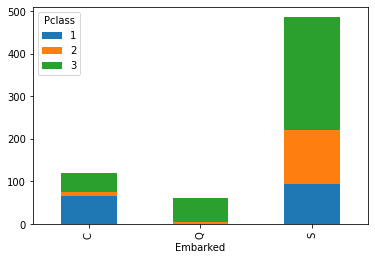

In [145]:
pd.crosstab(index = df_train.Embarked, columns = df_train.Pclass).plot.bar(stacked = True)
plt.show()

We can see here that a person in Pclass 1 is very unlikely to come from Q. Hence, we can narrow down the Embarked for these two C or S. 

Next, we investigate if Cabin can give us information.

In [146]:
df.loc[df.Cabin == 'B28']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,Miss
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,Mrs


In [147]:
df.Cabin.value_counts()

B96 B98            4
G6                 4
C23 C25 C27        4
F33                3
F2                 3
C22 C26            3
E101               3
D                  3
D35                2
D20                2
D26                2
D33                2
B77                2
C52                2
D36                2
B58 B60            2
D17                2
B5                 2
B49                2
B51 B53 B55        2
C92                2
C93                2
E121               2
C123               2
C124               2
C125               2
C83                2
C126               2
C78                2
C2                 2
C68                2
C65                2
B35                2
B57 B59 B63 B66    2
B28                2
F G73              2
B18                2
E8                 2
E67                2
B20                2
B22                2
E33                2
E44                2
E24                2
F4                 2
E25                2
C110               1
A32          

We see that those are the only two people in that Cabin, and as it is each Cabin is occupied by only one person. We can maybe see a correlation between the first letter of Cabin, and Embarked.

In [29]:
pd.set_option('display.max_rows', None)
df.loc[df.Deck == 'B'].Embarked.value_counts()

S    23
C    22
Q     0
Name: Embarked, dtype: int64

By just eyeballing it seems likely that the women come from C more than S.

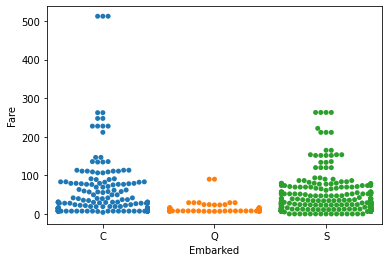

In [149]:
sns.swarmplot(df.Embarked, df.Fare)

Fare also doesn't give any information because at Fare 80, we have folks from both S and C. 

Hence, final decision: Set Embarked to C for these women.

In [179]:
df.Embarked.fillna("C", inplace = True)

Now, we have the problem of missing values in Age. Let's see what all Age is related to. Let's look again at the columns.

In [180]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Surname', 'Title'],
      dtype='object')

We should see why these are missing. Is there a correlation with missing or not (or the numeric value) and Pclass, Name (would have Mr, Mrs, Mister), SibSp, Parch, Fare, Cabin. (We already know that embarked doesn't give much information)

In [153]:
df[pd.isnull(df.Age)].Pclass.value_counts()/df.Pclass.value_counts()

3    0.276986
1    0.138889
2    0.059783
Name: Pclass, dtype: float64

The ratio of missing values seems to be increasing as we go from 1 to 3, but not very significantly. 

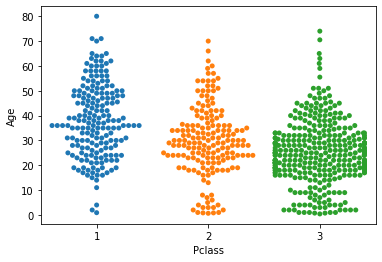

In [154]:
sns.swarmplot(x = df.Pclass, y = df.Age)

As we can see there is definitely a correlation between Pclass and Age. People in Pclass 1 tend to be older than people in Pclass 3. 

In [155]:
df[pd.isnull(df.Age)].Embarked.value_counts()/df.Embarked.value_counts()

C    0.223529
Q    0.636364
S    0.139752
Name: Embarked, dtype: float64

Oh my god! Number of missing values from Queenstown seem very high compared to others. What happened here? 

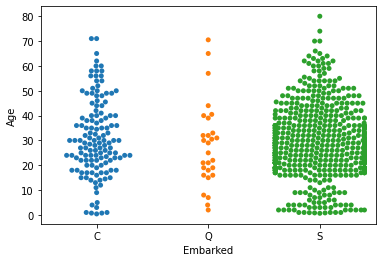

In [156]:
sns.swarmplot(x = df.Embarked, y = df.Age)

Maybe Queenstown being the last port, the ages were still being recorded. 

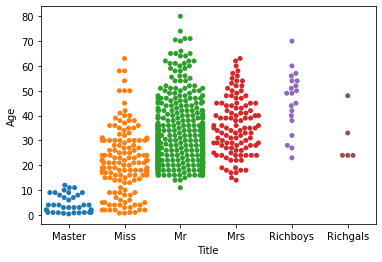

In [190]:
sns.swarmplot(df.Title, df.Age)

This plot clearly indicates that we need to average over titles atleast. For now we just mean over the title age.

In [199]:
median_ages = df.groupby(["Title", "Pclass"]).Age.transform("median")
df.Age = df.Age.fillna(median_ages)

In [203]:
df.loc[pd.isnull(df.Age)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title


Okay, so all missing values are dealt with except Cabin which we can't do anything about anyway. Now lets build our pipeline.

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer


numerical_transformer = SimpleImputer(strategy='mean')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ["Sex", "Title", "Embarked", "Deck", "Pclass"]),
        ('num', numerical_transformer, ["Age", "Fare", "SibSp", "Parch"])
    ])

model = RandomForestRegressor(n_estimators=1, random_state=0)

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

final_X_train = df_train[["Pclass", "Sex", "Age", "Title", "SibSp", "Parch", "Embarked", "Fare", "Deck"]]
y_train = df_train["Survived"]
final_X_dev = df_dev[["Pclass", "Sex", "Age", "Title", "SibSp", "Parch", "Embarked", "Fare", "Deck"]]
y_dev = df_dev["Survived"]

my_pipeline.fit(final_X_train, y_train)

# Preprocessing of validation data, get predictions
preds = np.round(list(my_pipeline.predict(final_X_dev)))

# Evaluate the model
from sklearn.model_selection import cross_val_score
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')


185    0.0
866    1.0
546    1.0
143    0.0
359    1.0
154    0.0
353    0.0
683    0.0
470    0.0
270    0.0
126    0.0
516    1.0
519    0.0
555    0.0
32     1.0
864    0.0
64     0.0
67     0.0
626    0.0
782    0.0
329    1.0
98     1.0
377    0.0
282    0.0
794    0.0
620    0.0
462    0.0
28     1.0
252    0.0
757    0.0
290    1.0
847    0.0
717    1.0
159    0.0
374    0.0
483    1.0
198    1.0
666    0.0
455    1.0
836    0.0
597    0.0
834    0.0
265    0.0
95     0.0
15     1.0
444    1.0
325    1.0
484    1.0
485    0.0
463    0.0
473    1.0
393    1.0
73     0.0
662    0.0
399    1.0
726    1.0
102    0.0
613    0.0
388    0.0
779    1.0
451    0.0
789    0.0
407    1.0
420    0.0
356    1.0
771    0.0
797    1.0
299    1.0
651    1.0
800    0.0
507    1.0
354    0.0
623    0.0
656    0.0
78     1.0
174    0.0
622    1.0
723    0.0
840    0.0
35     0.0
652    0.0
580    1.0
51     0.0
275    1.0
827    1.0
205    0.0
862    1.0
688    0.0
587    1.0
208    1.0
22     1.0